Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**This example introduces:**
1. Setting up material parameters and functions.
2. Setting up and solving systems, Stokes and Advection Diffusion.
3. The time stepping loop.
4. Plotting with glucifer.

**Keywords:** material parameters, Stokes system, advective diffusive systems

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math


Setup parameters
-----

In [2]:
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
res = 16
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh object has both a primary and sub mesh. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have nodes at the element corners, dQ0 elements have a single node at the elements centre.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (2*res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

Create mesh variables.  Note the pressure field uses the sub-mesh. 

In [4]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [5]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [6]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

Set top and bottom wall temperature boundary values.

In [7]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls.

In [8]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions can be found in the **Systems** section of the user guide.

In [9]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

**Render initial conditions for temperature**



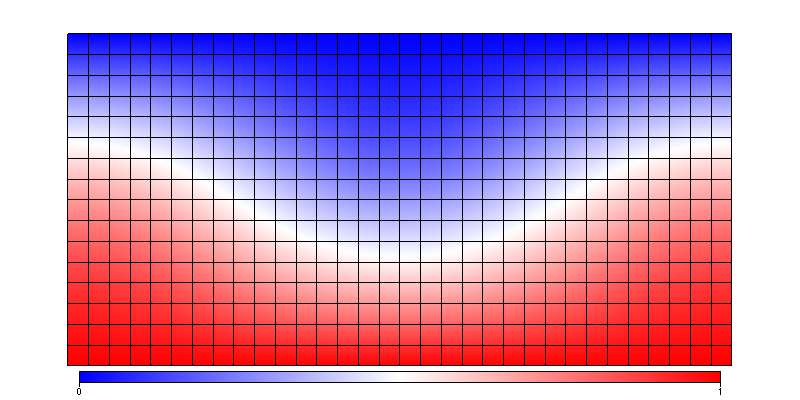

In [10]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

## Tools for smoothing and density of swarms

This machinery is supposed to work in parallel, and make use of the shadow particles
However, we may need to be careful when multiple procs at thinning / thickening swarms, and the shadow particle info could be changing. 




In [11]:
from unsupported_dan.interfaces.marker2D import markerLine2D

from unsupported_dan.interfaces.smoothing2D import *


import numpy as np


/workspace/sufaces/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [13]:
#laplacian2D(Line)

In [14]:
targetDist = 2./50
startDist = 2./100

dl = targetDist/1.2
du = 3.*(2.*(targetDist-dl))

lowDist = targetDist - dl
upDist = targetDist + du

xs = np.arange(0.1,mesh.maxCoord[0] - mesh.minCoord[0] - 0.1, startDist)

xs += 0.01*np.random.rand(xs.shape[0])

from matplotlib.pylab import shuffle
shuffle(xs)

##Let's mix up the coordinates



ys = 0.3*np.cos(np.pi*xs) + 0.5 + 0.05*np.cos(8*np.pi*xs) + 0.02*np.cos(30*np.pi*xs)  
ys += 0.01*np.random.rand(xs.shape[0])


Line = markerLine2D(mesh, velocityField, xs, ys, 0., 1.)


In [15]:
lowDist,upDist,targetDist

(0.006666666666666668, 0.08000000000000002, 0.04)

In [16]:
#%pylab inline
#plt.plot(Line.swarm.particleCoordinates.data[:,0])


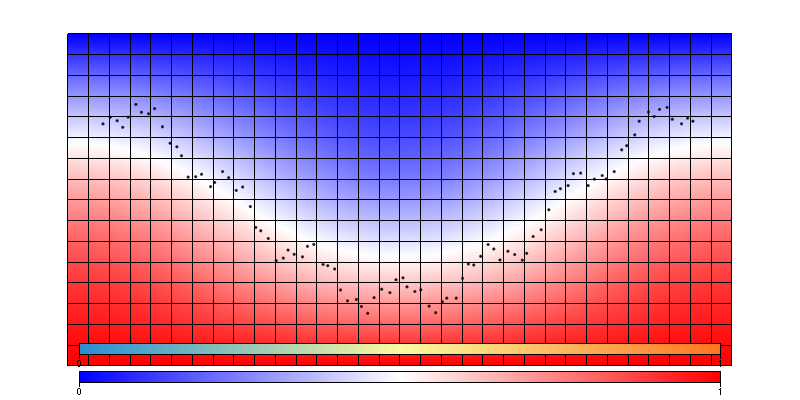

In [17]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.append(glucifer.objects.Points(Line.swarm, pointSize=4))
figtemp.show()

In [18]:
def neighboursMatrix(markerLine, k= False):
    
    """
    comment
    """

    #First, can we get the particle coordinates, using ids?
    #Yes
    
    all_particle_coords = markerLine.kdtree.data
    queryOut = markerLine.kdtree.query(all_particle_coords, k=markerLine.swarm.particleCoordinates.data.shape[0] )

    #distances = queryOut[0]
    ids = queryOut[1]
    
    coords = all_particle_coords[ids]

    #Now, can we make a vector array?
    #yes, using tile
    pvector = all_particle_coords[ids[:,0]]
    pcoords = np.tile(pvector, (all_particle_coords.shape[0],1,1)).swapaxes(0,1)
    vectors = np.subtract(coords, pcoords)

    #Now we have to compute the inner product pair ...
    #for the the nearest neighbour and all successive neighbours (we want to find one that is negative)

    #these are the x, y components of the nearest neighbours
    nnXVector = np.tile(vectors[:,1,0], (all_particle_coords.shape[0],1,1)).T.reshape(all_particle_coords.shape[0], all_particle_coords.shape[0])
    nnYVector = np.tile(vectors[:,1,1], (all_particle_coords.shape[0],1,1)).T.reshape(all_particle_coords.shape[0], all_particle_coords.shape[0])

    #now make the dot ptoduct
    xInnerCompare = (vectors[:,:,0] * nnXVector)
    yInnerCompare = (vectors[:,:,1] * nnYVector)
    dotProdCompare = xInnerCompare + yInnerCompare 

    #Now we want a boolean comparison for those 
    negDots = dotProdCompare < 0.
    
    #Here's where we limit the search
    if k:
        negDots[:,k:] = False
        

    #this should the the column of the first negative entry. To see which particle this corresponds to
    #cols = np.argmax(negDots[:,2:], axis = 1) + 2
    cols = np.argmax(negDots[:,:], axis = 1)
    #if cols is zero, it means no obtuse neighbour was found - likely an end particle.  For now, set to nearest neighbour
    cols[cols == 0] = 1
    
    
    answer = ids[np.arange(all_particle_coords.shape[0]),cols]


    #build the matrix of neighbour -adjacency
    AN = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))
    A0 = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))

    #First add the nearest neighbour
    AN[ids[:,0],ids[np.arange(len(AN)), 1]] =  1
    #now add the first neigbour that is obtuse to the first
    A0[ids[:,0],answer] =  1
    
    return AN, A0
    
    
    

In [21]:
#AN, A0 = obtuseNeighboursMatrix(Line)

In [22]:
AN, A0 = neighboursMatrix(Line)
A0

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
#%pylab inline
#plt.imshow(L)
#plt.imshow(angles)

In [26]:
#L = laplacian2D(Line)

#L.shape

In [27]:
#all_particle_coords = Line.kdtree.data
#queryOut = Line.kdtree.query(all_particle_coords, k=3)
#neighbours = queryOut[1][:,1:]
#neighbours.shape

In [28]:
#Later we'll make methods for the the marker Line / surface class. 

def laplacian2D(markerLine):
    dims = markerLine.swarm.particleCoordinates.data.shape[1]
    
    #Get neighbours
    all_particle_coords = markerLine.kdtree.data
    #queryOut = markerLine.kdtree.query(all_particle_coords, k=dims + 1)
    #neighbours = queryOut[1][:,1:]
    
    AN, A0 = neighboursMatrix(Line)

    neighbours = np.column_stack((np.argwhere(AN == 1)[:,1], np.argwhere(A0 == 1)[:,1]))
    
    
    #build the Laplacian matrix - dense matrix for now. #Points will be unordered, so have to build using nieghbour / adjacency info
    #Build the diagonal 
    L = 2.*np.eye(all_particle_coords.shape[0])
    #fill in the neighbours (http://stackoverflow.com/questions/23435782)
    L[np.arange(len(L)), [neighbours[:,0],neighbours[:,1]]] = -1
        
    return L
    
    
def shadowMask(markerLine):
    """
    This needs doing better
    Al I want to do is test membership of local processor swarm, 
    with the local + shadow space swarm
    
    """
    
    
    all_particle_coords = markerLine.kdtree.data
    m1 = np.in1d(Line.swarm.particleCoordinates.data[:,0], all_particle_coords[:,0])
    m2 = np.in1d(Line.swarm.particleCoordinates.data[:,1], all_particle_coords[:,1])

    mask = []
    for i in range(len(m1)):
        if m1[i] == True == m2[i]:
            mask.append(True)
        else:
            mask.append(False)
    
    
    return np.array(mask)
  
    
    
def laplaceSmooth(markerLine, its, lam):
    """
    this includes my current solution for utilising the shadow space data
    We build th Laplcian using the full particle coordinate data (accessed through kdtree.data):
    our update looks like:
    lam * np.dot(L,Line.kdtree.data[mask]
    mask returns ony those particles on the local processor, hence on LHS:
    swarm.particleCoordinates.data[:]
    """
    for i in range(its):
        #Build Laplacian operator
        L = laplacian2D(markerLine)
        #build mask
        mask = shadowMask(markerLine)
        with markerLine.swarm.deform_swarm():
            markerLine.swarm.particleCoordinates.data[:] -= lam * np.dot(L,markerLine.kdtree.data[mask])
    
        #Rebuild Line
        markerLine.rebuild() #having this here slows thing down quite a bit

    
    

In [29]:
all_particle_coords = Line.kdtree.data
queryOut = Line.kdtree.query(all_particle_coords, k=Line.swarm.particleCoordinates.data.shape[0] )

distances = queryOut[0]
ids = queryOut[1]
#neighbours = all_particle_coords[ids[tId]]
#vectors = p - neighbours[1:]



In [44]:
from unsupported_dan.interfaces.smoothing2D import *


NameError: name 'add_particles_to_pairs' is not defined

In [45]:
def add_particles_to_pairs(markerLine, _dist):
    
    all_particle_coords = markerLine.kdtree.data
    #A, ends = obtuseNeighboursMatrix(markerLine, k = 20)
    AN, A0 = neighboursMatrix(Line, k = 20)
    
    A = AN + A0
    
    pd = pairDistanceMatrix(markerLine)
    pdMask = pd > _dist
    AF = A*pdMask
    
    uniques = np.transpose(np.nonzero(AF))
    #First, store a complete copy of the new particle positions (mean pair positions)
    newPoints = np.copy(0.5*(all_particle_coords[uniques[:,0]] + all_particle_coords[uniques[:,1]]))
    markerLine.add_points(newPoints[:,0], newPoints[:,1])
    print("added {} particles to Swarm".format(newPoints.shape[0]))

In [46]:
add_particles_to_pairs(Line, upDist)
Line.rebuild()

added 5 particles to Swarm


In [55]:
#First, can we get the particle coordinates, using ids?
#Yes

all_particle_coords = Line.kdtree.data
queryOut = Line.kdtree.query(all_particle_coords, k=Line.swarm.particleCoordinates.data.shape[0] )
ids = queryOut[1]
coords = all_particle_coords[ids]

#Now, can we make a vector array?
#yes, using tile
pvector = all_particle_coords[ids[:,0]]
pcoords = np.tile(pvector, (all_particle_coords.shape[0],1,1)).swapaxes(0,1)
vectors = np.subtract(coords, pcoords)

#Now we have to compute the inner product pair ...
#for the the nearest neighbour and all successive neighbours (we want to find one that is negative)

#these are the x, y components of the nearest neighbours
nnXVector = np.tile(vectors[:,1,0], (all_particle_coords.shape[0],1,1)).T.reshape(all_particle_coords.shape[0], all_particle_coords.shape[0])
nnYVector = np.tile(vectors[:,1,1], (all_particle_coords.shape[0],1,1)).T.reshape(all_particle_coords.shape[0], all_particle_coords.shape[0])

#now make the dot ptoduct
xInnerCompare = (vectors[:,:,0] * nnXVector)
yInnerCompare = (vectors[:,:,1] * nnYVector)
dotProdCompare = xInnerCompare + yInnerCompare 

#Now we want a boolean comparison for those 
negDots = dotProdCompare < 0.

#this should the the column of the first negative entry. To see which particle this corresponds to
#cols = np.argmax(negDots[:,2:], axis = 1) + 2
cols = np.argmax(negDots[:,:], axis = 1)
#if cols is zero, it means no obtuse neighbour was found - likely an end particle.  For now, set to nearest neighbour
cols[cols == 0] = 1

answer = ids[np.arange(all_particle_coords.shape[0]),cols]


#build the matrix of neighbour -adjacency
AN = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))
A0 = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))

#First add the nearest neighbour
AN[ids[:,0],ids[np.arange(len(AN)), 1]] =  1
#now add the first neigbour that is obtuse to the first
A0[ids[:,0],answer] =  1

In [48]:
cols = np.argmax(negDots[:,:], axis = 1)
cols[cols == 0] = 1


In [49]:
answer = ids[np.arange(all_particle_coords.shape[0]),cols]

In [50]:
answer

array([36, 79, 71, 72, 81, 53, 11, 41, 77, 29, 66,  6, 17, 58, 19, 11, 51,
       12, 37, 29, 60, 58, 88, 30, 86, 66, 34, 81, 66, 19, 23, 18, 55, 55,
       78, 36, 56, 84, 73, 57, 10, 13, 58,  6, 78, 26, 42, 49, 54, 47, 74,
       14, 67, 81, 48, 33, 36, 12, 13, 82, 20, 75, 68, 84, 20,  3, 25, 52,
       15, 45, 71, 75,  3, 38, 50,  7, 17,  2, 16, 80, 67, 83, 52, 53, 63,
       72, 40, 15, 18,  0])

In [51]:
A0 = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))


    #now add the first subsequent neigbour that is obtuse to the first
A0[ids[:,0],answer] =  1

In [57]:
A0.shape, A0.sum(axis=1).sum()

((95, 95), 95.0)

In [102]:
def neighboursAngleMatrix(markerLine):
    
    all_particle_coords = markerLine.kdtree.data
    queryOut = markerLine.kdtree.query(all_particle_coords, k=markerLine.swarm.particleCoordinates.data.shape[0] )
    coords = all_particle_coords[ids]


    pvector = all_particle_coords[ids[:,0]]
    pcoords = np.tile(pvector, (all_particle_coords.shape[0],1,1)).swapaxes(0,1)
    vectors = np.subtract(coords, pcoords)
    nearNeigbourNorm = np.linalg.norm(np.tile(vectors[:,1], (all_particle_coords.shape[0],1,1)), axis = 2)
    otherNbsNorms = np.linalg.norm(vectors, axis = 2)
    normMult = nearNeigbourNorm.T*otherNbsNorms #Tranpose here because of sloppiness in above line
    cosThetas = np.divide(dotProdCompare,normMult)
    angles = np.arccos(cosThetas)
    pi2mask = angles>np.pi
    angles[pi2mask] -= np.pi
    
    return angles

In [101]:
#

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in arccos
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater


(90, 90)

In [55]:
#np.rad2deg(angles[np.arange(all_particle_coords.shape[0]),cols])


#nnnorm = np.linalg.norm(vectors[:,1], axis =1)
#nearNeigbourNorm = np.tile(nnnorm, (all_particle_coords.shape[0],1,1)).reshape(all_particle_coords.shape[0], all_particle_coords.shape[0])
#nearNeigbourNorm.T[:,1]

(array([  3.,   0.,   0.,   0.,   0.,  26.,  13.,  15.,  19.,  14.]),
 array([   0.        ,   17.84138484,   35.68276969,   53.52415453,
          71.36553937,   89.20692422,  107.04830906,  124.8896939 ,
         142.73107875,  160.57246359,  178.41384843]),
 <a list of 10 Patch objects>)

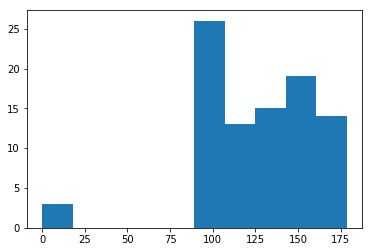

In [78]:
#test = np.rad2deg(angles[np.arange(all_particle_coords.shape[0]),cols])
#test = np.nan_to_num(test) 
#plt.hist(test)




In [57]:
#%pylab inline
#plt.scatter(Line.kdtree.data[:,0], Line.kdtree.data[:,1])
#plt.scatter(Line.kdtree.data[119,0], Line.kdtree.data[119,1], c='r', s=50)


In [58]:
#all_particle_coords = Line.kdtree.data
#A2, ends = obtuseNeighboursMatrix(Line, k = 20)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


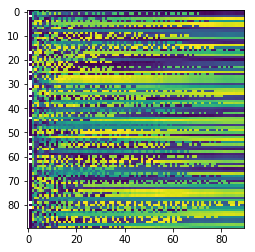

In [79]:
#%pylab inline
#plt.imshow(AN + A0)
#plt.imshow(angles)


In [61]:
def obtuseNeighboursMatrix(markerLine,  k =10):

    all_particle_coords = markerLine.kdtree.data
    queryOut = markerLine.kdtree.query(all_particle_coords, k=k )
    
    distances = queryOut[0]
    ids = queryOut[1]
    #mainmask = distances  != inf    

    #do this as a loop, coz vectorising it defeated me (+ crying baby)
    obIndexes = []
    ends = []

    for tId in range(all_particle_coords.shape[0]):
        #print(tId)
        p= all_particle_coords[tId]
        
        neighbours = all_particle_coords[ids[tId]]
        vectors = p - neighbours[1:]

        #now look for the first negative value in column 0
        signArray = np.sign(np.dot((vectors), (vectors).T))[:,0]

        #this is the index of the obtuse neighbour
        try:
            _obIndex = np.where(signArray == -1)[0][0]
            obIndexes.append(_obIndex )
        except:
            obIndexes.append(0)
            ends.append(tId)
        #vectors
    
    #build the matrix of neighbour -adjacency
    A = np.zeros((all_particle_coords.shape[0],all_particle_coords.shape[0] ))
    
    #First add the nearest neighbour
    A[ids[:,0],ids[np.arange(len(A)), 1]] =  1
    
    #now add the first neigbour that is obtuse to the first
    A[ids[:,0],ids[np.arange(len(A)), np.array(obIndexes) + 1 ]] =  1
    
    
    return A, ends


def pairDistance(markerLine):
    partx = markerLine.kdtree.data[:,0]
    party = markerLine.kdtree.data[:,1]
    dx = np.subtract.outer(partx , partx )
    dy = np.subtract.outer(party, party)
    distanceMatrix = np.hypot(dx, dy)
    
    return distanceMatrix

In [62]:
def thin_random(markerLine, _dist, fac=0.1):
    pd = pairDistance(markerLine)
    pdMask = pd < _dist
    uniques = np.transpose(np.nonzero(pdMask))
    np.random.shuffle(uniques)
    index = int(uniques.shape[0]*fac)
    uniques = uniques[:index]

   #Now get rid of the chosen ones
    with markerLine.swarm.deform_swarm():
        markerLine.swarm.particleCoordinates.data[uniques.flatten()] = (99999, 99999)
        
    print("removed {} particles from Swarm".format(uniques.shape[0]))
    
    
def add_particles_to_pairs(markerLine, _dist):
    
    all_particle_coords = markerLine.kdtree.data
    A, ends = obtuseNeighboursMatrix(markerLine, k = 20)
    pd = pairDistance(markerLine)
    pdMask = pd > _dist
    AF = A*pdMask
    
    uniques = np.transpose(np.nonzero(AF))
    #First, store a complete copy of the new particle positions (mean pair positions)
    newPoints = np.copy(0.5*(all_particle_coords[uniques[:,0]] + all_particle_coords[uniques[:,1]]))
    markerLine.add_points(newPoints[:,0], newPoints[:,1])
    print("added {} particles to Swarm".format(newPoints.shape[0]))
    


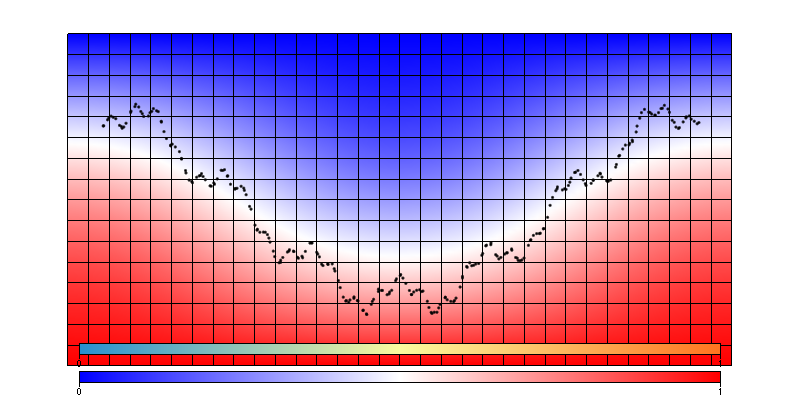

In [173]:
figtemp.show()

## Test

## Package it up

In [181]:
for i in range (2):

    add_particles_to_pairs(Line,upDist)
    Line.rebuild()
    
    its = 300
    lam = 0.0001*(mesh.maxCoord[0] - mesh.minCoord[0])
    laplaceSmooth(Line, its, lam)
    
    Line.rebuild()
    thin_random(Line, lowDist, fac=0.1)
    
    Line.rebuild()
    its = 300
    lam = 0.0001*(mesh.maxCoord[0] - mesh.minCoord[0])
    laplaceSmooth(Line, its, lam)
    
    
    Line.rebuild()
    add_particles_to_pairs(Line,upDist)
    
    

added 2 particles to Swarm
removed 37 particles from Swarm
added 18 particles to Swarm
added 0 particles to Swarm
removed 30 particles from Swarm
added 23 particles to Swarm



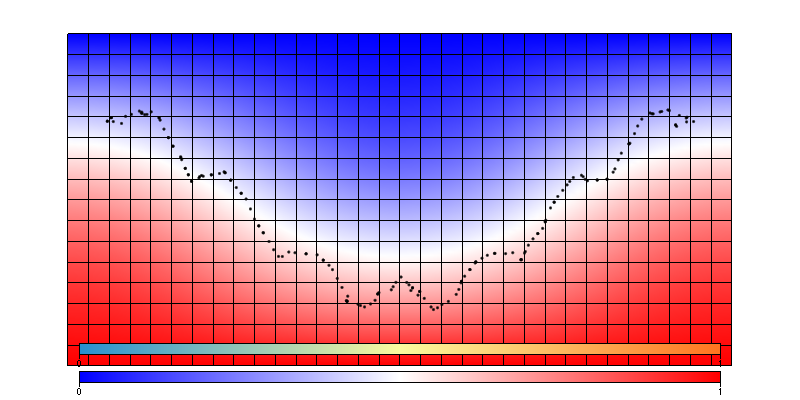

In [182]:
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the incompressible Stokes equations.  

In [129]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [12]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = tempBC )

Main time stepping loop
-----

In [13]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection-diffusion system.
    dt = advDiff.get_max_dt()
    # Advect using this timestep size.
    advDiff.integrate(dt)
    return time+dt, step+1

In [14]:
# init these guys
time = 0.
step = 0
steps_end = 20

# perform timestepping
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    time, step = update()

**Plot final temperature and velocity field**


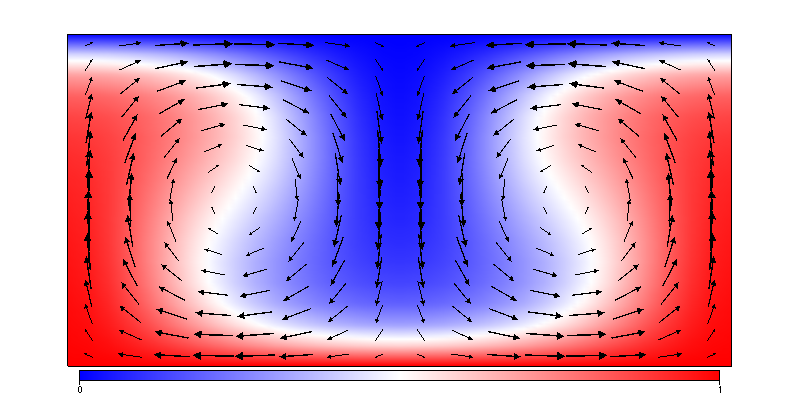

In [15]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()

## Scratch

In [543]:
def thin_clusters(markerLine, dist):
    
    clusters = 1
    count = 0
    dims = markerLine.swarm.particleCoordinates.data.shape[1]

    #Find columns of the adjaceny matrix with more than one entry, and remove these particles. 
    #We do this, until no columns have multiple entries
    while clusters and (count < 10):

        Line.rebuild()
        all_particle_coords = markerLine.kdtree.data

        queryOut = markerLine.kdtree.query(all_particle_coords, k=dims,distance_upper_bound=dist )
        masks = queryOut[0][:,1] < 1.
        #dists=queryOut[0][:,1][masks]
        ids = queryOut[1][masks]

        A = np.zeros((masks.shape[0],masks.shape[0] ))
        #for row in range(ids[:,0].shape[0]):
        #    A[ids[row,0], ids[row,1]] = 1
        A[ids[:,0],ids[:,1]] =  1


        clusterIds = A.sum(axis=0) > 1
        clusters = sum(clusterIds) #This will break the loop

        with markerLine.swarm.deform_swarm():
            markerLine.swarm.particleCoordinates.data[clusterIds ] = (99999, 99999)

        count += 1

        print('cycle')

    #The adjaceny matrix should now be symmetric. If not, print warning:    
    if not np.all(A == A.T):
        ("The adjaceny matrix is not Symmetric as it should be,this probably indicates a problem with the swarm / function")

def thin_pairs(markerLine, dist):  
    
    dims = markerLine.swarm.particleCoordinates.data.shape[1]

    #Part 2, all remaining pairs of particles get merged (mean pair positions)
    #rebuild the info

    markerLine.rebuild()
    all_particle_coords = markerLine.kdtree.data
    queryOut = markerLine.kdtree.query(all_particle_coords, k=dims,distance_upper_bound=dist )
    masks = queryOut[0][:,1] < 99999. #i.e avoid inf
    ids = queryOut[1][masks]
    smask = shadowMask(Line)

    #Rebuild adjacency matrix, and pull out the non zero entries below the diagonal
    #This is just a way of getting a unique set of pairs
    A = np.zeros((masks.shape[0],masks.shape[0] ))
    A[ids[:,0],ids[:,1]] =  1
    Alow = np.tril(A)
    AlowLocal = Alow[smask, :][:,smask] #this should collect only the local particles
    uniques = np.transpose(np.nonzero(AlowLocal))

    #First, store a complete copy of the new particle positions (mean pair positions)
    newPoints = np.copy(0.5*(all_particle_coords[uniques[:,0]] + all_particle_coords[uniques[:,1]]))

    #Now get rid of the old ones
    with markerLine.swarm.deform_swarm():
        markerLine.swarm.particleCoordinates.data[uniques.flatten()] = (99999, 99999)
        
    print("removed {} particles from Swarm".format(uniques.shape[0]))

